*Data source:*

- [*FAOSTAT: Food and Agriculture Organization of the United Nations*](https://www.fao.org/faostat/en/#release_calendar)
- [*The world bank*](https://databank.worldbank.org/)
- *https://www.worldeconomics.com/*

**Table of contents**<a id='toc0_'></a>    
1. [Import libraries and other useful code.](#toc1_)    
2. [Read, clean and arrange datasets.](#toc2_)    
2.1. [Crop dataset](#toc2_1_)    
2.2. [Precipitations dataset](#toc2_2_)    
2.2.1. [Preprocessing](#toc2_2_1_) 
2.2.1.1. [NaN values](#toc2_2_1_1_)
2.3. [Pesticides dataset](#toc2_3_)  
2.3.1. [Preprocessing](#toc2_3_1_) 
2.3.1.1. [Outliers](#toc2_3_1_1_)   
2.4. [Fertilizers dataset](#toc2_4_)    
2.4.1. [Preprocessing](#toc2_4_1_)
2.4.1.1. [NaN values](#toc2_4_1_1_) 
2.4.1.2. [Outliers](#toc2_4_1_2_) 
2.5. [Temperature dataset](#toc2_5_)    
3. [Create final dataframe.](#toc3_)    
3.1. [Preprocessing](#toc3_1_) 
3.1.1. [NaN values](#toc3_1_1_) 
3.1.2. [Outliers](#toc3_1_2_) 

---
## 1. <a id='toc1_'></a>[Import libraries and other useful code](#toc0_)

In [114]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [200]:
# define color palette
agro = ['#b2cb91','#9bc27e','#7fa465','#668f4f','#4e6f43','#59533e','#bf9000','#ffd966','#ffe599']

In [201]:
sns.set(style="whitegrid")  # Seaborn Grid Style

In [ ]:
# Set the display of numbers in decimal notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 2. <a id='toc2_'></a>[Read, clean and arrange datasets](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Crop dataset](#toc0_)

In [388]:
crop = pd.read_csv('Data/crop_yield/Production_Crops_Livestock_E_All_Data_Normalized.csv',encoding='latin-1', low_memory=False) # low_memory = False to avoid Dtypewarning

In [389]:
crop.shape

(4127584, 14)

In [390]:
# To have the same years in the datasets, filter the datasets from year 1990
crop = crop[crop['Year']>=1990]

In [391]:
crop.head()

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
29,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1990,1990,ha,6037.00,E,NaN
30,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1991,1991,ha,5500.00,A,NaN
31,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1992,1992,ha,5500.00,A,NaN
32,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1993,1993,ha,5500.00,A,NaN
33,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1994,1994,ha,5500.00,A,NaN


In [392]:
# Delete innecessary columns
crop.drop(columns=['Area Code', 'Area Code (M49)','Item Code (CPC)','Element Code','Unit','Year Code','Flag','Note'], inplace=True)

In [393]:
crop['Element'].unique()

array(['Area harvested', 'Yield', 'Production', 'Stocks',
       'Producing Animals/Slaughtered', 'Laying', 'Yield/Carcass Weight',
       'Milk Animals', 'Prod Popultn'], dtype=object)

In [394]:
# delete element types
delete_elements = ['Stocks', 'Laying', 'Milk Animals', 'Prod Popultn', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight']

# Filter the DataFrame to exclude the rows with the specified elements, and keep area harvested, yield and production
crop = crop[~crop['Element'].isin(delete_elements)]

In [395]:
# Change the name to Elements type
crop['Element'] = crop['Element'].replace('Area harvested', 'area_harvested_ha')
crop['Element'] = crop['Element'].replace('Yield', 'yield_hg/ha')
crop['Element'] = crop['Element'].replace('Production', 'production_tonnes')

In [396]:
crop['Element'].value_counts()

Element
production_tonnes    903506
yield_hg/ha          548517
area_harvested_ha    505826
Name: count, dtype: int64

In [397]:
# pivot.table creates a DataFrame where the items are separated into columns according to the type of item, keeping the relationship with the columns Area, Item and Year.

crop = crop.pivot_table(index=['Area', 'Item Code', 'Item', 'Year'], columns='Element', values='Value').reset_index()
# index: The columns we want to keep unchanged in the resulting DataFrame.
# columns: The column whose values will be used to create the new columns in the resulting DataFrame.
# values: The column whose values will be used to populate the resulting DataFrame. 

In [398]:
# Change the name to the Item column
crop.rename(columns={'Item': 'Crop'}, inplace=True)

In [127]:
crop.head()

Element,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,1990,1570000.0,1650000.0,10510.0
1,Afghanistan,15,Wheat,1991,1690000.0,1726000.0,10213.0
2,Afghanistan,15,Wheat,1992,1600000.0,1650000.0,10313.0
3,Afghanistan,15,Wheat,1993,1900000.0,1940000.0,10211.0
4,Afghanistan,15,Wheat,1994,2000000.0,2050000.0,10250.0


### 2.2. <a id='toc2_2_'></a>[Precipitations dataset](#toc0_)

In [399]:
prec = pd.read_csv('Data/TWB_avg_precip/0b1dbe54-6204-43c1-8bd8-dbbc6763a4dd_Series - Metadata.csv',encoding='latin-1') # Average precipitation in depth (mm per year)

In [400]:
# Delete innecessary columns
prec.drop(columns=['Series Name', 'Series Code','Country Code'], inplace=True)

In [401]:
# Change name columns
col = prec.columns
# Apply the regular expression using comprehension lists
years = [re.search(r'\d{4}', x).group() if re.search(r'\d{4}', x) else 'Area' for x in col]
# Change name columns with the new list years
prec.columns = years

In [402]:
prec.head()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,..,..,..
1,Albania,1485,1485,1485,1485,1485,1485,1485,1485,1485,...,1485,1485,1485,1485,1485,1485,1485,..,..,..
2,Algeria,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,..,..,..
3,American Samoa,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Andorra,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


In [403]:
prec.tail()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,Indicator Name,Source,Topic,Periodicity,Development relevance,Limitations and exceptions,License URL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Average precipitation in depth (mm per year),"Food and Agriculture Organization, electronic ...",Environment: Land use,Annual,The agriculture sector is the most water-inten...,The data are collected by the Food and Agricul...,https://datacatalog.worldbank.org/public-licen...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [404]:
# delete the last two rows
prec = prec.iloc[:-2]

There are a lot of nan in the back rows, this will be addressed in the preprocessing section.

In [405]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    266 non-null    object
 2   1991    266 non-null    object
 3   1999    266 non-null    object
 4   2000    266 non-null    object
 5   2001    266 non-null    object
 6   2002    266 non-null    object
 7   2003    266 non-null    object
 8   2004    266 non-null    object
 9   2005    266 non-null    object
 10  2006    266 non-null    object
 11  2007    266 non-null    object
 12  2014    266 non-null    object
 13  2015    266 non-null    object
 14  2016    266 non-null    object
 15  2017    266 non-null    object
 16  2018    266 non-null    object
 17  2019    266 non-null    object
 18  2020    266 non-null    object
 19  2021    266 non-null    object
 20  2022    266 non-null    object
 21  2023    266 non-null    object
dtypes: object(22)
memory usage

#### 2.2.1. <a id='toc2_2_1_'></a>[Preprocessing](#toc0_)

##### 2.2.1.1. <a id='toc2_2_1_1_'></a>[NaN values](#toc2_2_1_1_)

In [406]:
# replace .. by NaN
prec.replace('..', np.nan, inplace=True)

C:\Users\kina5\AppData\Local\Temp\ipykernel_18204\2314844775.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prec.replace('..', np.nan, inplace=True)


<Axes: >

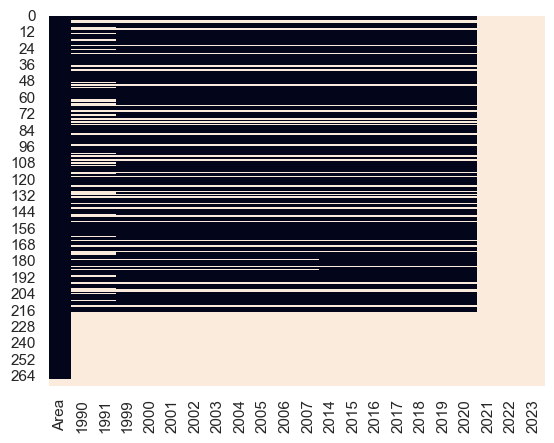

In [407]:
sns.heatmap(prec.isnull(), cbar=False) # Visualize null values with a heatmap

In [408]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area     1.85
1990    42.07
1991    42.07
1999    33.58
2000    33.58
2001    33.58
2002    33.58
2003    33.58
2004    33.58
2005    33.58
2006    33.58
2007    33.58
2014    32.84
2015    32.84
2016    32.84
2017    32.84
2018    32.84
2019    32.84
2020    32.84
2021   100.00
2022   100.00
2023   100.00
dtype: float64

In [409]:
# percentage of nan values (rows)
prec.isnull().sum(axis=1) / prec.shape[1] * 100

0      13.64
1      13.64
2      13.64
3      95.45
4      95.45
       ...  
266   100.00
267   100.00
268   100.00
269   100.00
270   100.00
Length: 271, dtype: float64

In [410]:
# # Calculate the percentage of null values in each row
percent_missing_rows = prec.isnull().sum(axis=1) / prec.shape[1] * 100

# Filter out rows with a percentage of nulls = 100
missing_rows = percent_missing_rows[percent_missing_rows==100].index

# Display rows with a percentage of nulls = 100
prec.loc[missing_rows]

# delete missing_rows
prec.drop(missing_rows, inplace=True)

In [411]:
# no information of the columns 2021, 2022, 2023. Delete

prec.drop(columns=['2021', '2022','2023'], inplace=True)

In [412]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area    0.00
1990   40.98
1991   40.98
1999   32.33
2000   32.33
2001   32.33
2002   32.33
2003   32.33
2004   32.33
2005   32.33
2006   32.33
2007   32.33
2014   31.58
2015   31.58
2016   31.58
2017   31.58
2018   31.58
2019   31.58
2020   31.58
dtype: float64

In [413]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    157 non-null    object
 2   1991    157 non-null    object
 3   1999    180 non-null    object
 4   2000    180 non-null    object
 5   2001    180 non-null    object
 6   2002    180 non-null    object
 7   2003    180 non-null    object
 8   2004    180 non-null    object
 9   2005    180 non-null    object
 10  2006    180 non-null    object
 11  2007    180 non-null    object
 12  2014    182 non-null    object
 13  2015    182 non-null    object
 14  2016    182 non-null    object
 15  2017    182 non-null    object
 16  2018    182 non-null    object
 17  2019    182 non-null    object
 18  2020    182 non-null    object
dtypes: object(19)
memory usage: 39.6+ KB


In [414]:
prec.columns

Index(['Area', '1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

In [415]:
# Change the number columns type to float
year_col = ['1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020']
prec[year_col]= prec[year_col].astype(float)

As the rainfall values are mm per year and they are continuous variables, we will do the imputation with the mean value of mm per year:

In [416]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in prec.columns:
    repair_null(prec, col)

prec.isnull().sum()/len(prec)*100

Area   0.00
1990   0.00
1991   0.00
1999   0.00
2000   0.00
2001   0.00
2002   0.00
2003   0.00
2004   0.00
2005   0.00
2006   0.00
2007   0.00
2014   0.00
2015   0.00
2016   0.00
2017   0.00
2018   0.00
2019   0.00
2020   0.00
dtype: float64

In [417]:
# calculation of the average rain fall from 1990-present in a new column

prec['avg_rainfall_mm_year'] = prec[year_col].mean(axis=1).round(2)

In [418]:
# create a new df with Area and average columns
prec_filtered = prec[['Area','avg_rainfall_mm_year']].copy()

In [170]:
prec_filtered

,Area,avg_rainfall_mm_year
0,Afghanistan,327.00
1,Albania,1485.00
2,Algeria,89.00
3,American Samoa,1183.25
4,Andorra,1183.25
...,...,...
261,Sub-Saharan Africa,1183.25
262,Sub-Saharan Africa (excluding high income),1183.25
263,Sub-Saharan Africa (IDA & IBRD countries),1183.25
264,Upper middle income,1183.25


### 2.3. <a id='toc2_3_'></a>[Pesticides dataset](#toc0_)

In [434]:
pest = pd.read_csv('Data/pesticides_use/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv',encoding='latin-1',low_memory=False)

In [435]:
# To have the same years in the datasets, filter the datasets from year 1990
pest = pest[pest['Year']>=1990]

In [436]:
pest.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1990,1990,t,121.00,E,NaN
1,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1991,1991,t,121.00,E,NaN
2,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1992,1992,t,121.00,E,NaN
3,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1993,1993,t,121.00,E,NaN
4,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1994,1994,t,201.00,E,NaN


In [437]:
pest['Element'].unique()

array(['Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [438]:
# delete element types
delete_elements = ['Use per capita','Use per area of cropland','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
pest = pest[~pest['Element'].isin(delete_elements)]

In [439]:
# create new filtered df
pest_filtered = pest[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
pest_filtered.rename(columns={'Item': 'pesticides_type'}, inplace=True)
pest_filtered.rename(columns={'Value': 'agricultural_use_tonnes'}, inplace=True)
# Delete Element column
pest_filtered.drop(columns=['Element'], inplace=True)

In [440]:
pest_filtered['pesticides_type'].unique()

array(['Pesticides (total)', 'Insecticides',
       'Insecticides \x96 Chlorinated Hydrocarbons',
       'Insecticides \x96 Organo-phosphates',
       'Insecticides \x96 Carbamates', 'Insecticides \x96 Pyrethroids',
       'Insecticides \x96 Other', 'Herbicides',
       'Herbicides \x96 Phenoxy hormone products',
       'Herbicides \x96 Triazines', 'Herbicides \x96 Amides',
       'Herbicides \x96 Carbamates', 'Herbicides \x96 Dinitroanilines',
       'Herbicides \x96 Sulfonyl ureas', 'Herbicides \x96 Bipiridils',
       'Herbicides \x96 Other', 'Fungicides and Bactericides',
       'Fung & Bact \x96 Inorganics', 'Fung & Bact \x96 Dithiocarbamates',
       'Fung & Bact \x96 Benzimidazoles',
       'Fung & Bact \x96 Triazoles, diazoles', 'Fung & Bact \x96 Other',
       'Fungicides \x96 Seed treatments',
       'Insecticides \x96 Seed Treatments', 'Plant Growth Regulators',
       'Rodenticides', 'Rodenticides \x96 Anti-coagulants',
       'Rodenticides \x96 Other', 'Other Pesticides ne

In [441]:
# Clean pesticides_type column
pest_filtered['pesticides_type'] = pest_filtered['pesticides_type'].str.replace('\x96', ':')

In [442]:
#Create a new column grouping pesticides_type:

# Iterate over the rows of the DataFrame 
for index, row in pest_filtered.iterrows():
    pesticide_type = row['pesticides_type']
    
    if pesticide_type.startswith('Insecticides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Insecticides' #  to assign the value to the pesticide group to each cell individually in the column 'pesticides_group' 
    elif pesticide_type.startswith('Herbicides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Herbicides'
    elif pesticide_type.startswith('Fung & Bact') or pesticide_type.startswith('Fungicides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Fungicides and Bactericides'
    elif pesticide_type.startswith('Rodenticides'):
        pest_filtered.at[index, 'pesticides_group'] = 'Rodenticides'
    elif pesticide_type.startswith('Seed Treat'):
        pest_filtered.at[index, 'pesticides_group'] = 'Seed Treatments'
    else:
        pest_filtered.at[index, 'pesticides_group'] = pesticide_type

In [443]:
pest_filtered['pesticides_group'].unique()

array(['Pesticides (total)', 'Insecticides', 'Herbicides',
       'Fungicides and Bactericides', 'Plant Growth Regulators',
       'Rodenticides', 'Other Pesticides nes', 'Mineral Oils',
       'Disinfectants', 'Seed Treatments'], dtype=object)

#### 2.3.1. <a id='toc2_3_1_'></a>[Preprocessing](#toc0_)

In [444]:
pest_filtered.isnull().sum()

Area                       0
pesticides_type            0
Year                       0
agricultural_use_tonnes    0
pesticides_group           0
dtype: int64

#### 2.3.1.1. <a id='toc2_3_1_1_'></a>[Outliers](#toc0_)

In [445]:
pest_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91564 entries, 0 to 112332
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     91564 non-null  object 
 1   pesticides_type          91564 non-null  object 
 2   Year                     91564 non-null  int64  
 3   agricultural_use_tonnes  91564 non-null  float64
 4   pesticides_group         91564 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.2+ MB


In [446]:
pest_filtered['agricultural_use_tonnes'].describe().T.round(2)

count     91564.00
mean       8054.67
std       71881.59
min           0.00
25%           0.63
50%          32.01
75%         504.50
max     3531959.08
Name: agricultural_use_tonnes, dtype: float64

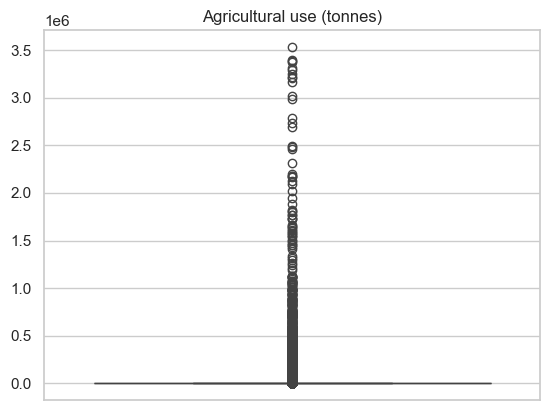

In [463]:
# Create boxplot
pest_var = pest_filtered['agricultural_use_tonnes']
ax = sns.boxplot(y=pest_var, data=pest_filtered, color = agro[3]) 
ax.set_title('Agricultural use (tonnes)')
ax.set_ylabel('')  

plt.show()

In [464]:
# repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
def repair_outliers(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_lower = Q1 - (1.5 * IQR)
    outlier_upper = Q3 + (1.5 * IQR)
    
    for i in range(len(df[col.name])): 
        if i in df.index:  
            element = df.loc[i, col.name] 
            if element > outlier_upper: 
                df.loc[i, col.name] = outlier_upper
            elif element < outlier_lower: 
                df.loc[i, col.name] = outlier_lower
            
    return df  

repair_outliers(pest_filtered, pest_var)

,Area,pesticides_type,Year,agricultural_use_tonnes,pesticides_group
0,Albania,Pesticides (total),1990,121.00,Pesticides (total)
1,Albania,Pesticides (total),1991,121.00,Pesticides (total)
2,Albania,Pesticides (total),1992,121.00,Pesticides (total)
3,Albania,Pesticides (total),1993,121.00,Pesticides (total)
4,Albania,Pesticides (total),1994,201.00,Pesticides (total)
...,...,...,...,...,...
112328,Net Food Importing Developing Countries,Other Pesticides nes,2017,1603.95,Other Pesticides nes
112329,Net Food Importing Developing Countries,Other Pesticides nes,2018,1419.14,Other Pesticides nes
112330,Net Food Importing Developing Countries,Other Pesticides nes,2019,1457.76,Other Pesticides nes
112331,Net Food Importing Developing Countries,Other Pesticides nes,2020,1845.11,Other Pesticides nes


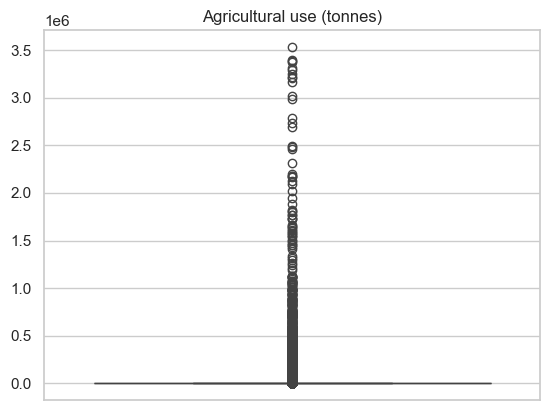

In [465]:
# Create boxplot

ax = sns.boxplot(y=pest_var, data=pest_filtered, color = agro[3]) 
ax.set_title('Agricultural use (tonnes)')
ax.set_ylabel('')  

plt.show()

In [191]:
# Save pest_filtered in csv:
# pest_filtered.to_csv('Data/pest_preprocessed.csv', index=False)

### 2.4. <a id='toc2_4_'></a>[Fertilizers dataset](#toc0_)

In [372]:
fert = pd.read_csv('Data/fertilizers/Inputs_FertilizersNutrient_E_All_Data_Normalized.csv',encoding='latin-1',low_memory=False)

In [373]:
# To have the same years in the datasets, filter the datasets from year 1990
fert_filtered = fert[fert['Year']>=1990]

In [155]:
fert.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1974,1974,t,19117.0,A,Official data from questionnaire
1,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1975,1975,t,14774.0,A,Official data from questionnaire
2,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1976,1976,t,26203.0,A,Official data from questionnaire
3,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1977,1977,t,37689.0,A,Official data from questionnaire
4,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1978,1978,t,48300.0,A,Official data from questionnaire


In [156]:
fert['Element'].unique()

array(['Production', 'Import Quantity', 'Export Quantity',
       'Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [374]:
# delete element types
delete_elements = ['Import Quantity', 'Export Quantity', 'Use per capita','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
fert = fert[~fert['Element'].isin(delete_elements)]
# Change the name to Elements type
fert['Element'] = fert['Element'].replace('Production', 'production_tonnes')
fert['Element'] = fert['Element'].replace('Agricultural Use', 'agricultural_use_tonnes')
fert['Element'] = fert['Element'].replace('Use per area of cropland', 'use_per_area_kg/ha')

In [375]:
# create new filtered df
fert_filtered = fert[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
fert_filtered.rename(columns={'Item': 'fertilizer_type'}, inplace=True)

In [159]:
fert_filtered['Element'].value_counts()

Element
agricultural use_tonnes    35760
use per area_kg/ha         35655
production_tonnes          19888
Name: count, dtype: int64

In [376]:
# pivot.table creates a DataFrame where the items are separated into columns according to the type of item, keeping the relationship with the columns Area, fertilizer_type and Year.

fert_filtered = fert_filtered.pivot_table(index=['Area', 'fertilizer_type', 'Year'], columns='Element', values='Value').reset_index()

In [306]:
fert_filtered.head(2)

Element,Area,fertilizer_type,Year,agricultural_use_tonnes,production_tonnes,use_per_area_kg/ha
0,Afghanistan,Nutrient nitrogen N (total),1961,1000.00,NaN,0.13
1,Afghanistan,Nutrient nitrogen N (total),1962,1000.00,NaN,0.13


In [307]:
fert_filtered['fertilizer_type'].value_counts()

fertilizer_type
Nutrient nitrogen N (total)        12295
Nutrient phosphate P2O5 (total)    11964
Nutrient potash K2O (total)        11657
Name: count, dtype: int64

#### 2.4.1. <a id='toc2_4_1_'></a>[Preprocessing](#toc0_)

##### 2.4.1.1. <a id='toc2_4_1_1_'></a>[NaN values](#toc0_)

In [377]:
fert_filtered.isnull().sum()

Element
Area                           0
fertilizer_type                0
Year                           0
agricultural_use_tonnes      156
production_tonnes          16028
use_per_area_kg/ha           261
dtype: int64

In [378]:
fert_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35916 entries, 0 to 35915
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     35916 non-null  object 
 1   fertilizer_type          35916 non-null  object 
 2   Year                     35916 non-null  int64  
 3   agricultural_use_tonnes  35760 non-null  float64
 4   production_tonnes        19888 non-null  float64
 5   use_per_area_kg/ha       35655 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.6+ MB


As the **agricultural use, production and use per area** are continuous variables, we will do the imputation with the mean value:

In [379]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in fert_filtered.columns:
    repair_null(fert_filtered, col)

fert_filtered.isnull().sum()/len(prec)*100

Element
Area                      0.00
fertilizer_type           0.00
Year                      0.00
agricultural_use_tonnes   0.00
production_tonnes         0.00
use_per_area_kg/ha        0.00
dtype: float64

##### 2.4.1.2. <a id='toc2_4_1_2_'></a>[Outliers](#toc0_)

In [380]:
# convert year variable to object type, because it's a discrete variable
fert_filtered['Year'] = fert_filtered['Year'].astype(object)

In [381]:
fert_filtered.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Element,,,,,,,,
agricultural_use_tonnes,35916.00,960964.59,4638662.76,0.00,1739.51,24491.50,230637.25,110541658.96
production_tonnes,35916.00,1827674.20,4892066.96,0.00,55000.00,1827674.20,1827674.20,122741092.16
use_per_area_kg/ha,35916.00,28.16,40.82,0.00,2.41,12.40,36.38,412.29


In [382]:
# visualise outliers: This function prints the outliers for each column.

def outliers (df):
    for columns in df:
        if df[columns].dtype in ['int64', 'float64']: 

            Q1 = df[columns].quantile(0.25)
            Q3 = df[columns].quantile(0.75)
            IQR = Q3 - Q1
            outlierLeft = Q1-(1.5*IQR)
            outlierRight = Q3+(1.5*IQR)
            outliers = df[columns][(df[columns] < outlierLeft) | (df[columns] > outlierRight)]
            print("Variable " + columns + " has " + str(len(outliers)) + " outliers")

    
outliers(fert_filtered)

Variable agricultural_use_tonnes has 5852 outliers
Variable production_tonnes has 1920 outliers
Variable use_per_area_kg/ha has 2932 outliers


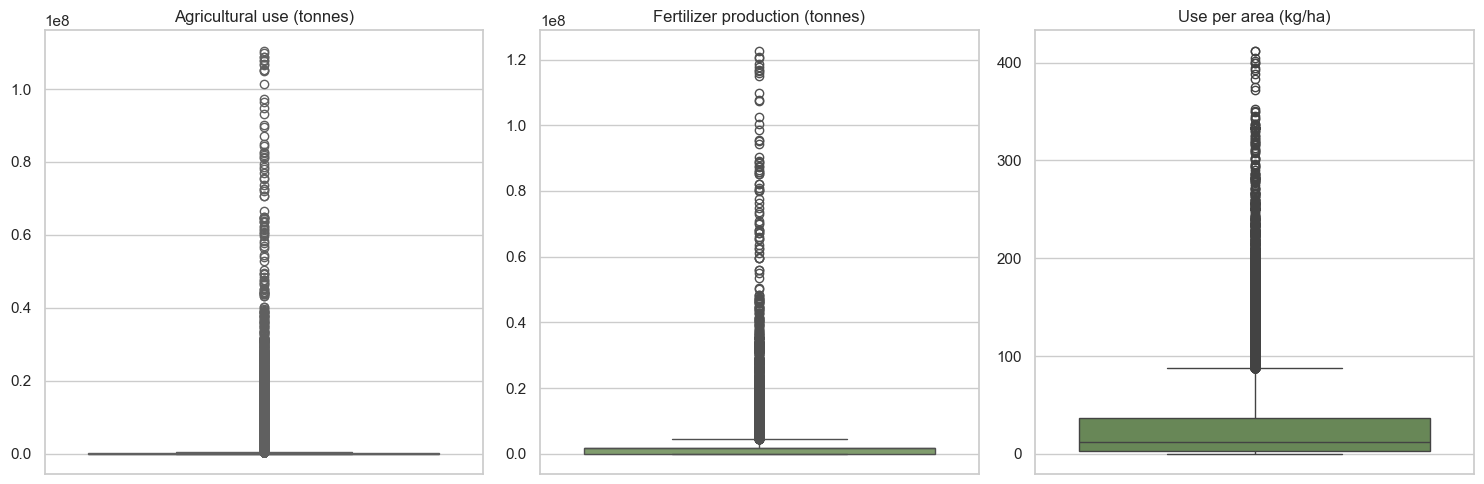

In [383]:
# Create boxplot
fert_var1 = fert_filtered['agricultural_use_tonnes']
fert_var2 = fert_filtered['production_tonnes']
fert_var3 = fert_filtered['use_per_area_kg/ha']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

fig = sns.boxplot(y=fert_var1, data=df, ax=axes[0], color = agro[1]) 
axes[0].set_title('Agricultural use (tonnes)')
axes[0].set_ylabel('')  

fig = sns.boxplot(y=fert_var2, data=df, ax=axes[1], color = agro[2]) 
axes[1].set_title('Fertilizer production (tonnes)')
axes[1].set_ylabel('') 

fig = sns.boxplot(y=fert_var3, data=df, ax=axes[2], color = agro[3])  
axes[2].set_title('Use per area (kg/ha)')
axes[2].set_ylabel('')  

# Adjust the design
plt.tight_layout()

# Show
plt.show()

In [384]:
# repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
def repair_outliers(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_lower = Q1 - (1.5 * IQR)
    outlier_upper = Q3 + (1.5 * IQR)
    
    for i in range(len(df[col.name])): 
        if i in df.index:  
            element = df.loc[i, col.name] 
            if element > outlier_upper: 
                df.loc[i, col.name] = outlier_upper
            elif element < outlier_lower: 
                df.loc[i, col.name] = outlier_lower
            
    return df  

repair_outliers(fert_filtered, fert_var1)
repair_outliers(fert_filtered, fert_var2)
repair_outliers(fert_filtered, fert_var3)

Element,Area,fertilizer_type,Year,agricultural_use_tonnes,production_tonnes,use_per_area_kg/ha
0,Afghanistan,Nutrient nitrogen N (total),1961,1000.00,1827674.20,0.13
1,Afghanistan,Nutrient nitrogen N (total),1962,1000.00,1827674.20,0.13
2,Afghanistan,Nutrient nitrogen N (total),1963,1000.00,1827674.20,0.13
3,Afghanistan,Nutrient nitrogen N (total),1964,1000.00,1827674.20,0.13
4,Afghanistan,Nutrient nitrogen N (total),1965,1000.00,1827674.20,0.13
...,...,...,...,...,...,...
35911,Zimbabwe,Nutrient potash K2O (total),2017,40000.00,0.00,9.76
35912,Zimbabwe,Nutrient potash K2O (total),2018,36900.00,0.00,9.00
35913,Zimbabwe,Nutrient potash K2O (total),2019,36900.00,0.00,9.00
35914,Zimbabwe,Nutrient potash K2O (total),2020,16700.00,0.00,4.07


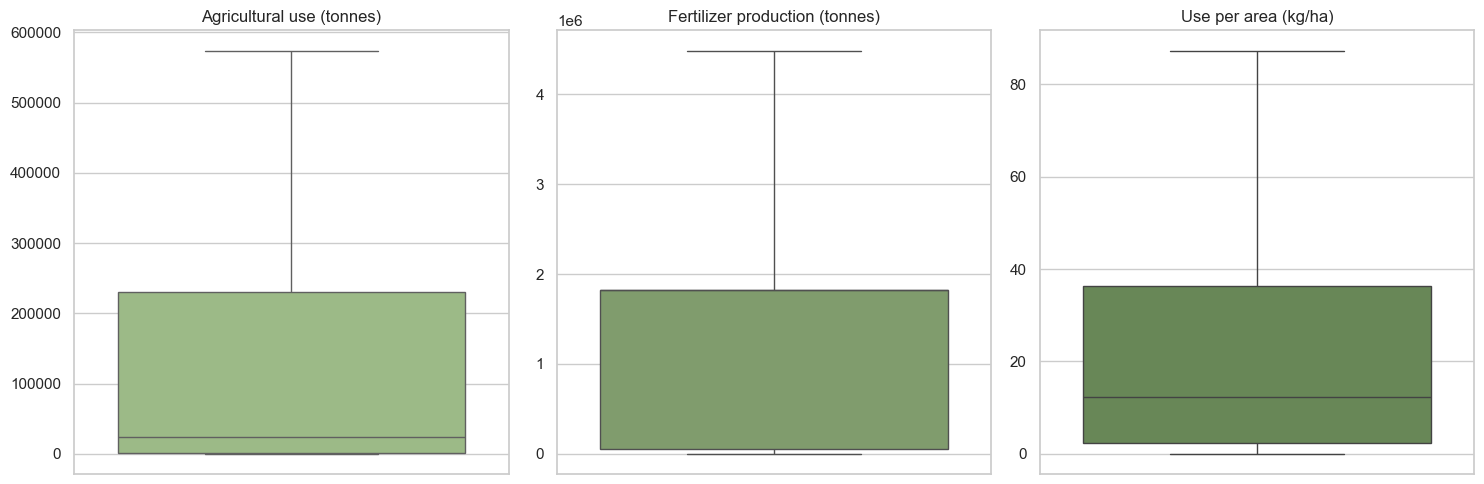

In [385]:
# boxplot
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

fig = sns.boxplot(y=fert_var1, data=fert_filtered, ax=axes[0], color = agro[1]) 
axes[0].set_title('Agricultural use (tonnes)')
axes[0].set_ylabel('')  

fig = sns.boxplot(y=fert_var2, data=fert_filtered, ax=axes[1], color = agro[2]) 
axes[1].set_title('Fertilizer production (tonnes)')
axes[1].set_ylabel('') 

fig = sns.boxplot(y=fert_var3, data=fert_filtered, ax=axes[2], color = agro[3])  
axes[2].set_title('Use per area (kg/ha)')
axes[2].set_ylabel('')  

plt.tight_layout()
plt.show()

In [386]:
# Save fert_filtered in csv:
fert_filtered.to_csv('Data/fert_preprocessed.csv', index=False)

### 2.5. <a id='toc2_5_'></a>[Temperature dataset](#toc0_)

In [419]:
# Data: https://tradingeconomics.com/country-list/temperature
temp = {
    'Country': [
        'Burkina Faso', 'Mali', 'Qatar', 'Senegal', 'United Arab Emirates', 'Mauritania', 'Bahrain',
        'Aruba', 'Djibouti', 'Gambia', 'Benin', 'Maldives', 'Guinea Bissau', 'Cayman Islands',
        'Oman', 'Marshall Islands', 'Kiribati', 'Ghana', 'Singapore', 'Niger', 'Kuwait', 'Sudan',
        'Guam', 'Palau', 'Samoa', 'Togo', 'Micronesia', 'St Kitts and Nevis', 'American Samoa',
        'Chad', 'Cambodia', 'Northern Mariana Islands', 'Sri Lanka', 'Nigeria', 'Seychelles',
        'Somalia', 'Antigua and Barbuda', 'Ivory Coast', 'Virgin Islands', 'St Lucia', 'Thailand',
        'Dominica', 'Sierra Leone', 'Philippines', 'Suriname', 'Eritrea', 'Saudi Arabia',
        'Trinidad and Tobago', 'Barbados', 'Malaysia', 'Grenada', 'Guyana', 'Cuba', 'Bahamas',
        'Jamaica', 'St Vincent and the Grenadines', 'Indonesia', 'Guinea', 'Solomon Islands',
        'Belize', 'Nicaragua', 'Bangladesh', 'Central African Republic', 'Brazil', 'Venezuela',
        'Yemen', 'Liberia', 'Gabon', 'Panama', 'El Salvador', 'Kenya', 'India', 'Tonga',
        'Republic of the Congo', 'Haiti', 'Fiji', 'Cameroon', 'Puerto Rico', 'Equatorial Guinea',
        'Mayotte', 'Papua New Guinea', 'Vanuatu', 'Vietnam', 'Colombia', 'Honduras',
        'Sao Tome and Principe', 'Costa Rica', 'Dominican Republic', 'Mozambique', 'Congo',
        'Algeria', 'French Polynesia', 'Laos', 'Myanmar', 'Paraguay', 'Iraq', 'Guatemala',
        'Comoros', 'Hong Kong', 'Ethiopia', 'Macau', 'New Caledonia', 'Mauritius', 'Egypt',
        'Uganda', 'Tanzania', 'Libya', 'Madagascar', 'Cape Verde', 'Malawi', 'Pakistan',
        'Botswana', 'Australia', 'Zambia', 'Zimbabwe', 'Mexico', 'Angola', 'Tunisia', 'Ecuador',
        'Swaziland', 'Taiwan', 'Bolivia', 'Burundi', 'Malta', 'Namibia', 'Israel', 'Jordan',
        'Palestine', 'Peru', 'Cyprus', 'Iran', 'Syria', 'Rwanda', 'Morocco', 'South Africa',
        'Uruguay', 'Turkmenistan', 'Portugal', 'Lebanon', 'Spain', 'Argentina', 'Monaco',
        'Greece', 'Uzbekistan', 'Afghanistan', 'Nepal', 'Italy', 'San Marino', 'Azerbaijan',
        'Albania', 'Croatia', 'France', 'South Korea', 'Lesotho', 'Hungary', 'Serbia', 'Japan',
        'Bulgaria', 'Turkey', 'Belgium', 'Moldova', 'Netherlands', 'Macedonia', 'New Zealand',
        'Bosnia and Herzegovina', 'Luxembourg', 'Romania', 'Slovenia', 'Montenegro', 'Germany',
        'Bhutan', 'Ireland', 'United Kingdom', 'Ukraine', 'Georgia', 'Isle of Man', 'Slovakia',
        'Denmark', 'Andorra', 'United States', 'Czech Republic', 'Poland', 'Chile', 'Liechtenstein',
        'Austria', 'Armenia', 'China', 'Switzerland', 'Kazakhstan', 'Belarus', 'Lithuania',
        'North Korea', 'Latvia', 'Faroe Islands', 'Estonia', 'Tajikistan', 'Kyrgyzstan', 'Sweden',
        'Finland', 'Norway', 'Iceland', 'Mongolia', 'Russia', 'Canada', 'Greenland'
    ],
    'Last': [
    29.28, 29.19, 29.11, 29.00, 28.93, 28.9, 28.84, 28.82, 28.6, 28.46, 28.09, 28.08, 28.05, 28.01,
    27.94, 27.9, 27.77, 27.73, 27.7, 27.61, 27.58, 27.57, 27.54, 27.54, 27.53, 27.47, 27.45, 27.34,
    27.31, 27.28, 27.25, 27.25, 27.24, 27.15, 27.11, 27.1, 27.06, 26.84, 26.84, 26.83, 26.78, 26.68,
    26.64, 26.61, 26.53, 26.49, 26.46, 26.46, 26.45, 26.35, 26.33, 26.16, 26.14, 26.05, 26.02, 25.98,
    25.96, 25.95, 25.89, 25.83, 25.81, 25.74, 25.56, 25.54, 25.52, 25.51, 25.47, 25.46, 25.33, 25.23,
    25.22, 25.2, 25.1, 25.05, 25.01, 24.98, 24.94, 24.94, 24.89, 24.87, 24.78, 24.76, 24.73, 24.71,
    24.71, 24.66, 24.64, 24.57, 24.42, 24.38, 24.11, 24.05, 24.05, 23.96, 23.86, 23.81, 23.77, 23.74,
    23.62, 23.45, 23.4, 23.37, 23.27, 23.23, 23.14, 22.9, 22.8, 22.7, 22.67, 22.55, 22.23, 22.00,
    21.96, 21.92, 21.83, 21.7, 21.63, 21.44, 21.07, 20.92, 20.79, 20.68, 20.43, 20.26, 20.24, 20.23,
    19.77, 19.7, 19.58, 19.33, 19.3, 19.17, 19.14, 19.1, 18.42, 17.73, 17.66, 16.9, 15.66, 15.3, 15.07,
    15.01, 14.88, 14.86, 14.48, 14.39, 14.38, 14.14, 13.84, 13.31, 13.16, 13.16, 12.76, 12.64, 12.62,
    12.56, 12.42, 12.28, 12.24, 11.98, 11.9, 11.72, 11.66, 11.66, 11.57, 11.43, 11.2, 11.04, 11.00,
    10.83, 10.56, 10.35, 10.11, 10.04, 9.92, 9.89, 9.81, 9.77, 9.73, 9.73, 9.71, 9.7, 9.37, 9.05,
    8.65, 8.64, 8.1, 8.08, 8.06, 7.98, 7.95, 7.46, 7.4, 7.1, 6.9, 5.09, 3.93, 3.84, 3.24, 2.88,
    2.11, 1.31, -2.87, -4.22, -18.62
],
    'Previous': [
    30.01, 29.78, 29.42, 29.62, 29.09, 29.3, 29.18, 29.03, 28.52, 29.03, 28.7, 28.14, 28.68, 27.99,
    28.1, 28.16, 27.89, 28.3, 27.75, 28.09, 27.89, 28.17, 27.88, 27.58, 27.54, 28.04, 27.42, 27.6,
    27.34, 27.7, 27.44, 27.65, 27.4, 27.67, 27.26, 26.93, 27.33, 27.37, 27.11, 27.03, 26.9, 26.9,
    27.19, 26.7, 26.56, 26.88, 26.8, 26.58, 26.63, 26.47, 26.49, 26.15, 26.06, 25.87, 26.07, 26.16,
    26.01, 26.6, 25.89, 26.15, 26.09, 25.7, 25.78, 25.57, 25.61, 25.64, 25.87, 25.66, 25.59, 25.53,
    25.25, 25.09, 25.16, 25.23, 25.15, 25.03, 25.2, 25.17, 25.08, 25.08, 24.79, 24.66, 25.04, 24.97,
    25.03, 24.93, 24.89, 24.75, 24.53, 24.46, 23.92, 24.45, 24.34, 24.11, 24.01, 24.21, 24.08, 23.92,
    24.19, 23.41, 23.96, 23.09, 23.7, 23.88, 23.22, 23.0, 23.05, 22.87, 22.76, 22.8, 22.03, 21.74,
    22.05, 22.11, 21.87, 21.85, 21.74, 21.33, 21.42, 20.52, 21.07, 20.8, 20.51, 20.22, 20.12, 20.86,
    20.36, 20.34, 19.79, 19.87, 19.57, 19.67, 19.21, 18.48, 18.06, 18.06, 17.69, 16.1, 16.2, 14.31,
    15.4, 13.62, 15.09, 14.76, 14.28, 14.29, 13.52, 13.16, 13.9, 12.89, 12.19, 11.58, 13.14, 12.28,
    11.58, 11.7, 12.45, 11.97, 12.61, 10.48, 10.95, 10.41, 11.39, 11.18, 10.7, 9.77, 10.35, 10.0,
    10.25, 9.49, 10.73, 9.94, 9.39, 9.37, 10.05, 9.92, 8.79, 8.96, 8.38, 10.01, 8.5, 8.75, 9.81,
    7.44, 7.41, 8.81, 8.21, 6.39, 7.83, 7.33, 7.28, 7.81, 6.82, 6.7, 6.3, 4.61, 3.36, 3.08, 2.34,
    2.11, 2.43, 2.08, -3.65, -3.7, -17.6
]
}

temp = pd.DataFrame(temp)
temp


,Country,Last,Previous
0,Burkina Faso,29.28,30.01
1,Mali,29.19,29.78
2,Qatar,29.11,29.42
3,Senegal,29.00,29.62
4,United Arab Emirates,28.93,29.09
...,...,...,...
200,Iceland,2.11,2.43
201,Mongolia,1.31,2.08
202,Russia,-2.87,-3.65
203,Canada,-4.22,-3.70


In [420]:
# calculation of the average temperature last & previous in a new column

temp['avg_temp_ºC'] = temp[['Last','Previous']].mean(axis=1).round(2)

# drop Last & previous columns
temp = temp.drop(['Last','Previous'], axis=1)
# Change the name to the new column
temp.rename(columns={'Country': 'Area'}, inplace=True)

In [163]:
temp.head()

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48
2,Qatar,29.26
3,Senegal,29.31
4,United Arab Emirates,29.01


## 3. <a id='toc3_'></a>[Create final dataframe](#toc0_)

Merge crop & prec_filtered & temp

In [421]:
crop.shape

(893871, 7)

In [422]:
crop['Area'].nunique()

245

In [423]:
crop.head(2)

Element,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,1990,1570000.00,1650000.00,10510.00
1,Afghanistan,15,Wheat,1991,1690000.00,1726000.00,10213.00


In [338]:
prec_filtered.shape

(266, 2)

In [339]:
prec_filtered['Area'].nunique()

266

In [340]:
prec_filtered.head(2)

,Area,avg_rainfall_mm_year
0,Afghanistan,327.00
1,Albania,1485.00


In [341]:
temp.shape

(205, 2)

In [342]:
temp['Area'].nunique()

205

In [343]:
temp.head(2)

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48


There are more countries in the df prec_filtered. Let's merge them and use an inner join so that only rows that have matches in both tables are included in the column you use to join. Rows that do not have matches in both tables will not be included in the resulting DataFrame.

In [424]:
df = crop.merge(prec_filtered, on='Area', how='inner')
df = df.merge(temp, on='Area', how='inner')

In [425]:
df['Area'].nunique()

154

In [346]:
df.head()

,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
0,Afghanistan,15,Wheat,1990,1570000.00,1650000.00,10510.00,327.00,14.38
1,Afghanistan,15,Wheat,1991,1690000.00,1726000.00,10213.00,327.00,14.38
2,Afghanistan,15,Wheat,1992,1600000.00,1650000.00,10313.00,327.00,14.38
3,Afghanistan,15,Wheat,1993,1900000.00,1940000.00,10211.00,327.00,14.38
4,Afghanistan,15,Wheat,1994,2000000.00,2050000.00,10250.00,327.00,14.38


In [347]:
df.shape

(517523, 9)

### 3.1. <a id='toc3_1_'></a>[Preprocessing](#toc0_)

#### 3.1.1. <a id='toc3_1_1_'></a>[NaN values](#toc0_)

In [426]:
df.isnull().sum()

Area                         0
Item Code                    0
Crop                         0
Year                         0
area_harvested_ha       229775
production_tonnes          182
yield_hg/ha             212074
avg_rainfall_mm_year         0
avg_temp_ºC                  0
dtype: int64

In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517523 entries, 0 to 517522
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Area                  517523 non-null  object 
 1   Item Code             517523 non-null  int64  
 2   Crop                  517523 non-null  object 
 3   Year                  517523 non-null  int64  
 4   area_harvested_ha     287748 non-null  float64
 5   production_tonnes     517341 non-null  float64
 6   yield_hg/ha           305449 non-null  float64
 7   avg_rainfall_mm_year  517523 non-null  float64
 8   avg_temp_ºC           517523 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 35.5+ MB


As the **area harvested, production and yield** are continuous variables, we will do the imputation with the mean value:

In [427]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in df.columns:
    repair_null(df, col)

df.isnull().sum()/len(prec)*100

Area                   0.00
Item Code              0.00
Crop                   0.00
Year                   0.00
area_harvested_ha      0.00
production_tonnes      0.00
yield_hg/ha            0.00
avg_rainfall_mm_year   0.00
avg_temp_ºC            0.00
dtype: float64

#### 3.1.2. <a id='toc3_1_2_'></a>[Outliers](#toc0_)

In [428]:
# convert item code and year variables to object type, because although they are numerical they are discrete variables.
df['Item Code'] = df['Item Code'].astype(object)
df['Year'] = df['Year'].astype(object)

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517523 entries, 0 to 517522
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Area                  517523 non-null  object 
 1   Item Code             517523 non-null  object 
 2   Crop                  517523 non-null  object 
 3   Year                  517523 non-null  object 
 4   area_harvested_ha     517523 non-null  float64
 5   production_tonnes     517523 non-null  float64
 6   yield_hg/ha           517523 non-null  float64
 7   avg_rainfall_mm_year  517523 non-null  float64
 8   avg_temp_ºC           517523 non-null  float64
dtypes: float64(5), object(4)
memory usage: 35.5+ MB


In [353]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
area_harvested_ha,517523.00,249753.35,1585052.84,0.00,2483.00,220624.00,249753.35,103566966.00
production_tonnes,517523.00,902662.80,10808823.86,0.00,864.00,11000.00,100121.00,768594154.00
yield_hg/ha,517523.00,94999.91,147096.57,0.00,27586.00,94999.91,94999.91,8755278.00
avg_rainfall_mm_year,517523.00,1157.85,771.74,56.00,600.00,1020.00,1668.00,3205.11
avg_temp_ºC,517523.00,19.19,7.65,-3.96,12.37,21.85,25.56,29.65


In [429]:
# visualise outliers: This function prints the outliers for each column.

def outliers (df):
    for columns in df:
        if df[columns].dtype in ['int64', 'float64']: 

            Q1 = df[columns].quantile(0.25)
            Q3 = df[columns].quantile(0.75)
            IQR = Q3 - Q1
            outlierLeft = Q1-(1.5*IQR)
            outlierRight = Q3+(1.5*IQR)
            outliers = df[columns][(df[columns] < outlierLeft) | (df[columns] > outlierRight)]
            print("Variable " + columns + " has " + str(len(outliers)) + " outliers")

    
outliers(df)

Variable area_harvested_ha has 15366 outliers
Variable production_tonnes has 87185 outliers
Variable yield_hg/ha has 38682 outliers
Variable avg_rainfall_mm_year has 0 outliers
Variable avg_temp_ºC has 0 outliers


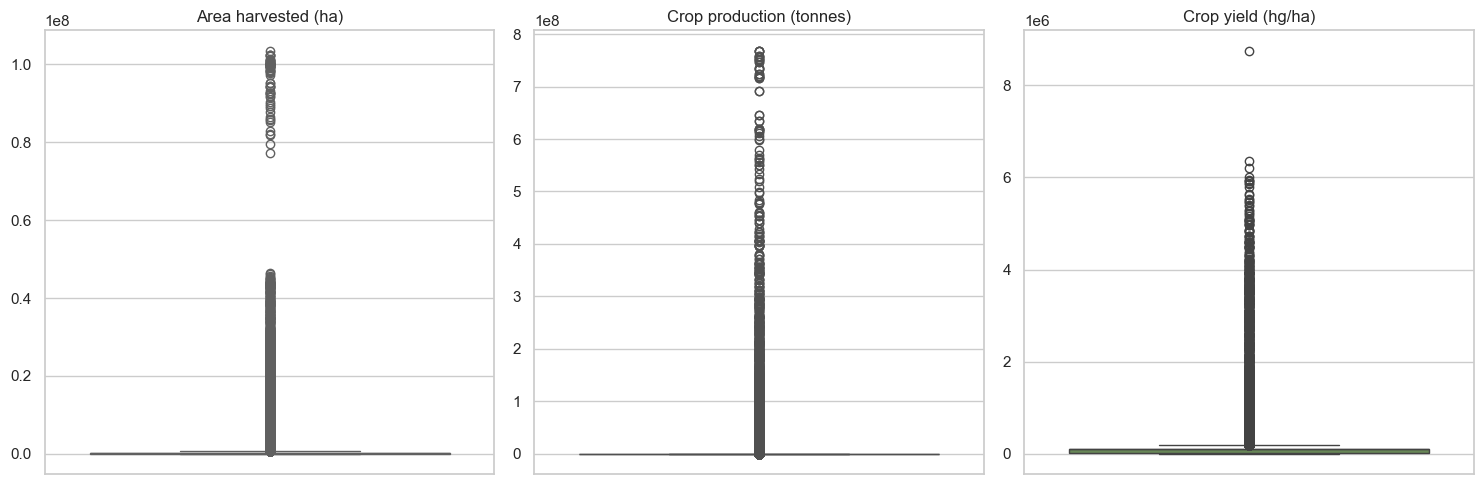

In [430]:
# Create boxplot
df_var1 = df['area_harvested_ha']
df_var2 = df['production_tonnes']
df_var3 = df['yield_hg/ha']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

fig = sns.boxplot(y=df_var1, data=df, ax=axes[0], color = agro[1]) 
axes[0].set_title('Area harvested (ha)')
axes[0].set_ylabel('')  

fig = sns.boxplot(y=df_var2, data=df, ax=axes[1], color = agro[2]) 
axes[1].set_title('Crop production (tonnes)')
axes[1].set_ylabel('') 

fig = sns.boxplot(y=df_var3, data=df, ax=axes[2], color = agro[3])  
axes[2].set_title('Crop yield (hg/ha)')
axes[2].set_ylabel('')  

# Adjust the design
plt.tight_layout()

# Show
plt.show()

In [431]:
# repair outliers: This function imputes the outliers in each column with the value of the IQR limit * 1.5 +- Q3.
def repair_outliers(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_lower = Q1 - (1.5 * IQR)
    outlier_upper = Q3 + (1.5 * IQR)
    
    for i in range(len(df[col.name])): 
        if i in df.index:  
            element = df.loc[i, col.name] 
            if element > outlier_upper: 
                df.loc[i, col.name] = outlier_upper
            elif element < outlier_lower: 
                df.loc[i, col.name] = outlier_lower
            
    return df  

repair_outliers(df, df_var1)
repair_outliers(df, df_var2)
repair_outliers(df, df_var3)

,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
0,Afghanistan,15,Wheat,1990,620658.88,249006.50,10510.00,327.00,14.38
1,Afghanistan,15,Wheat,1991,620658.88,249006.50,10213.00,327.00,14.38
2,Afghanistan,15,Wheat,1992,620658.88,249006.50,10313.00,327.00,14.38
3,Afghanistan,15,Wheat,1993,620658.88,249006.50,10211.00,327.00,14.38
4,Afghanistan,15,Wheat,1994,620658.88,249006.50,10250.00,327.00,14.38
...,...,...,...,...,...,...,...,...,...
517518,Zimbabwe,17530,"Fibre Crops, Fibre Equivalent",2018,133850.00,59693.17,4460.00,658.94,21.85
517519,Zimbabwe,17530,"Fibre Crops, Fibre Equivalent",2019,108612.00,35821.73,3298.00,658.94,21.85
517520,Zimbabwe,17530,"Fibre Crops, Fibre Equivalent",2020,119651.00,53009.87,4430.00,658.94,21.85
517521,Zimbabwe,17530,"Fibre Crops, Fibre Equivalent",2021,105266.00,69237.64,6577.00,658.94,21.85


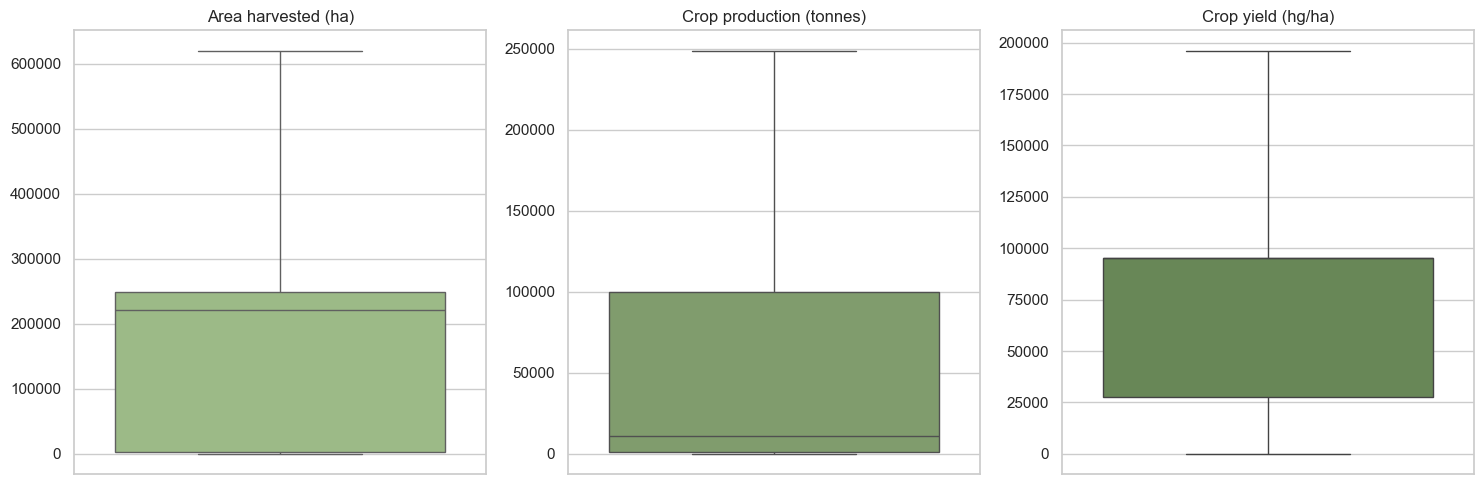

In [432]:
# Boxplot
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

fig = sns.boxplot(y=df_var1, data=df, ax=axes[0], color = agro[1]) 
axes[0].set_title('Area harvested (ha)')
axes[0].set_ylabel('')  

fig = sns.boxplot(y=df_var2, data=df, ax=axes[1], color = agro[2]) 
axes[1].set_title('Crop production (tonnes)')
axes[1].set_ylabel('') 

fig = sns.boxplot(y=df_var3, data=df, ax=axes[2], color = agro[3])  
axes[2].set_title('Crop yield (hg/ha)')
axes[2].set_ylabel('')  

plt.tight_layout()
plt.show()

In [433]:
# # Save final df in csv:
# df.to_csv('Data/df_preprocessed.csv', index=False)